<a href="https://colab.research.google.com/github/yuu067/MIA-IABD-2425/blob/main/UD04/notebooks/EX6.-entrenar_xarxa_neat_camera_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EX6: Entrenar un robot usando Aprendizaje por Refuerzo (NEAT)

## Introducción

En este cuaderno, entrenaremos a un robot para encontrar la mejor ruta para llegar a su destino. Usaremos NEAT (NeuroEvolution of Augmenting Topologies) para lograrlo. Neat es un algoritmo para el aprendizaje por refuerzo que utiliza redes neuronales para lograr su objetivo. Este algoritmo puede crear redes neuronales con topologías muy complejas y eficientes.
En este caso, el objetivo es encontrar la mejor ruta para llegar al destino. Comenzaremos desde las entradas y salidas de la red neuronal, y el algoritmo encontrará la mejor topología para lograr esto.

## Preparamos las librerías

Usaremos librerías `aitk` y `neat-python` para lograr nuestro objetivo. Comenzaremos por instalar las librerías necesarias.

In [1]:
%pip install aitk neat-python graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.4/310.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.6 MB/s eta 0:00:00


In [2]:
import aitk.robots as bots
from aitk.utils import Grid
from aitk.algorithms import neat

import numpy as np
import cv2
import requests
import matplotlib.pyplot as plt

## Neuroevolución

En este problema plantearemos las siguientes definiciones:

- **Gen**: Un gen será un nodo de red neuronal.
- **Cromosoma**: Un cromosoma será una red neuronal con los pesos correspondientes. Su tamaño será el número de pesos en la red neuronal.
- **Población**: Una población será un conjunto de cromosomas.

El mundo y el robot serán los mismos que en el cuaderno anterior.

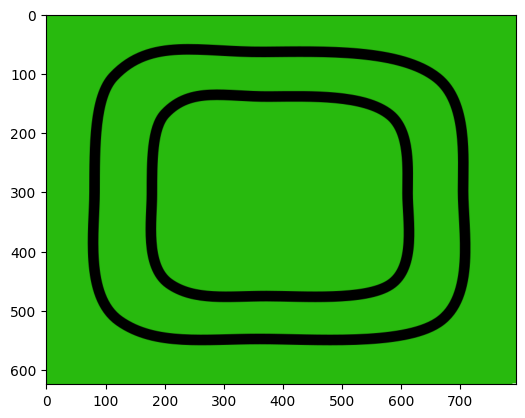

In [3]:
nom_imatge = "EX2_pista_6.png"

# Cargamos la imagen en una variable

img = cv2.imread(nom_imatge)

# Mostramos la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

amplada_camera = 120
alcada_camera = 50
robot = bots.Scribbler(x=36, y=80, a=90)
robot.add_device(bots.GroundCamera(width=amplada_camera, height=alcada_camera))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 6013033


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

Para calcular la aptitud de cada cromosoma, tendremos en cuenta la distancia recorrida por el robot. Si el robot sale de la matriz, su aptitud es 0.

Tendremos que implementar las siguientes funciones:

- `neat_controller`: Conductor para el robot. Aquí debemos buscar el centro de la imagen capturada por el robot y pasarla a la red neuronal, para calcular el siguiente movimiento y llevarla a cabo.
- `fitness`: Función para calcular la aptitud de cada cromosoma.

Las siguientes funciones y clases pueden ser útiles para calcular la aptitud:

- `aitk.utils.Grid`: Clase para representar una matriz. Pasamos el tamaño y el mundo para monitorear. Vemos algunas de sus funciones:
    - `grid.update(x, y)`: Actualiza el estado de una celda (para marcarlo como visitado),
    - `grid.analyze_visits()`: Calcule el porcentaje de células visitadas - de 0 si no hay celda visitada, a 1 si son todas.
    - `grid.draw()`: Muestra el estado actual de la matriz. Será muy útil para nosotros ver qué células han visitado el robot y cuáles no y recompensar esos cromosomas que visitan la mayoría de las células.
    - `grid.sequence`: nos devuelve una lista con las celdas visitadas por el robot. Será útil para nosotros calcular la aptitud y saber si el robot ha cambiado la matriz.
- `robot.stalled`: Función que nos dice si el robot está en una pared o no. Será útil calcular la aptitud, porque si el robot se detiene, su estado físico será 0. También podemos terminar el entrenamiento si se detiene el robot.
- `world.time`: Variable que nos dice el tiempo que ha pasado desde el comienzo del entrenamiento. Será útil para nosotros recompensar esos cromosomas que llegan al destino antes.

In [5]:
def neat_controller(robot):
    # Si ya nos hemos dado la vuelta, salimos
    #sequence = robot.state["grid"].sequence

    #if (4, 1) in sequence and (5, 1) in sequence:
    #    return True

    cam = robot['ground-camera']
    image = cam.get_image()

    # Convirtemos la imagen en una matriz numpy para trabajar en OpenCV
    im = np.array(image)

    # Nos quedamos con la parte superior de la imagen
    im_baix = im[00:20, 0:amplada_camera]

    # convertir a escala de grises
    im_bn = cv2.cvtColor(im_baix, cv2.COLOR_RGB2GRAY)

    # Aplicamos un filtro de ilusión
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)

    # Binarizamos la imagen
    ret, im_thresh = cv2.threshold(im_blurred, 100, 200, cv2.THRESH_BINARY)

    # Buscamos los contornos
    contours, hierarchy = cv2.findContours(im_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujamos los contornos
    cv2.drawContours(im_baix, contours, -1, (0, 255, 0), 1)


    # Definir las variables que se devuelven
    centre = 0

    # Calculamos el centro del borde más grande
    if len(contours) >= 2:
        cnt = max(contours, key=cv2.contourArea)
        M = cv2.moments(cnt)
        # En m tenemos los momentos de la imagen
        M00 = M['m00'] # area
        M10 = M['m10'] # sum(x)

        # Si el área es diferente de 0, calculamos el centro de masa
        if M00 != 0:
            centre = int(M10/M00)
            inputs = [centre/amplada_camera]
            out = robot.state["net"].activate(inputs)

        # Aumentamos la distancia recorrida
        x, y, a = robot.get_pose()
        robot.state["grid"].update(x, y)
        robot.state["grid"].draw()

        robot.move(out[0], out[1])
    else:
        robot.state["out"] = True
        return True

    if robot.stalled:
        return True


def fitness(net, seconds=60, real_time=False):
    # Evalúa el cromosoma y devuelve su valor físico

    # Mantenemos la red en el robot para usarla en el controlador
    robot.state["net"] = net

    # Volvemos a poner el robot en la posición inicial
    world.reset()
    robot.state["net"] = net
    robot.state["grid"] = Grid((10, 10), robot.world)
    robot.state["out"] = False

    # Ejecutamos el robot durante 100 segundos como máximo
    world.seconds(
        seconds, [neat_controller],
        real_time=real_time
    )

    # Calculamos el valor de fitness
    score = 0

    if not robot.stalled and not robot.state["out"]:
        visites  = robot.state["grid"].analyze_visits()
        score = visites*10 - world.time / 200


    return score

En NEAT también debemos definir una función de aptitud para toda la población

In [6]:
def eval_population(pop, config):
    """Esta función recibirá una población de cromosomas y los evaluará"""
    for genome_id, genome in pop:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = fitness(net, 60, real_time=False)


Por último, definimos cómo queremos que funcione el proceso evolutivo

In [7]:
def run(config_file):
    # Load configuration
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    # Uncomment this to save checkpoints every 5 generations
    # p.add_reporter(neat.Checkpointer(5))

    winner = p.run(eval_population, 50)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))
    node_names = {-1:'d1', -2:'d2', -3:'d3', -4:'timer',
                  -5:'stall', -6:'bias',
                  0:'translate', 1: 'rotate'}
    neat.visualize.draw_net(config, winner, True, node_names=node_names)
    neat.visualize.plot_stats(stats, ylog=False, view=True)
    neat.visualize.plot_species(stats, view=True)

    return winner

## Decisiones del alumno:
Decide primero cuantos inputs y outputs necesitamos:
- `num_inputs`
- `num_outputs`

Ahora prueba valores para los campos:
- `fitness_threshold`: Introducir un valor de fitness que creas que es suficiente (unidades)
- `pop_size`: Cuanto mayor sea la población, mayor será la variabilidad que habrá a expensas de más (decenas)

Realiza diferentes pruebas y justifica que ocurre con valores mayores o inferiores de estos dos últimos valores en una memória que deberas entregas al Profesor a través de AULES

In [8]:
%%writefile laberint.config
#--- parameters for the Robot Coverage experiment ---#

[NEAT]
fitness_criterion     = max
fitness_threshold     = 5
pop_size              = 10
reset_on_extinction   = False

[DefaultGenome]
# node activation options
activation_default      = tanh
activation_mutate_rate  = 0.0
activation_options      = tanh

# node aggregation options
aggregation_default     = sum
aggregation_mutate_rate = 0.0
aggregation_options     = sum

# node bias options
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1

# genome compatibility options
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.5

# connection add/remove rates
conn_add_prob           = 0.5
conn_delete_prob        = 0.5

# connection enable options
enabled_default         = True
enabled_mutate_rate     = 0.01

feed_forward            = True
initial_connection      = full

# node add/remove rates
node_add_prob           = 0.2
node_delete_prob        = 0.2

# network parameters
num_hidden              = 0
num_inputs              = 1
num_outputs             = 2

# node response options
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_max_value      = 30.0
response_min_value      = -30.0
response_mutate_power   = 0.0
response_mutate_rate    = 0.0
response_replace_rate   = 0.0

# connection weight options
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_max_value        = 30
weight_min_value        = -30
weight_mutate_power     = 0.5
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation       = 20
species_elitism      = 2

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2

Writing laberint.config


  0%|          | 0/600 [00:00<?, ?it/s]

Simulation stopped at: 00:00:00.80; speed 11.89 x real time
Population's average fitness: 0.00000 stdev: 0.00000
Best fitness: 0.00000 - size: (2, 2) - species 1 - id 1
Average adjusted fitness: 0.000
Mean genetic distance 0.714, standard deviation 0.548
Population of 10 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   49    10      0.0    0.000    49
Total extinctions: 0
Generation time: 1.397 sec (1.614 average)

Best genome:
Key: 1
Fitness: 0
Nodes:
	0 DefaultNodeGene(key=0, bias=-1.2725396864549134, response=1.0, activation=tanh, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.8052859794301412, response=1.0, activation=tanh, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-1, 0), weight=-0.39955686001234153, enabled=True)
	DefaultConnectionGene(key=(-1, 1), weight=-1.3006195905390245, enabled=True)


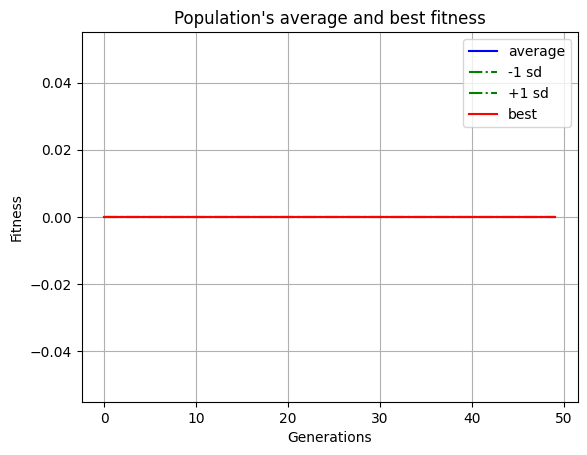

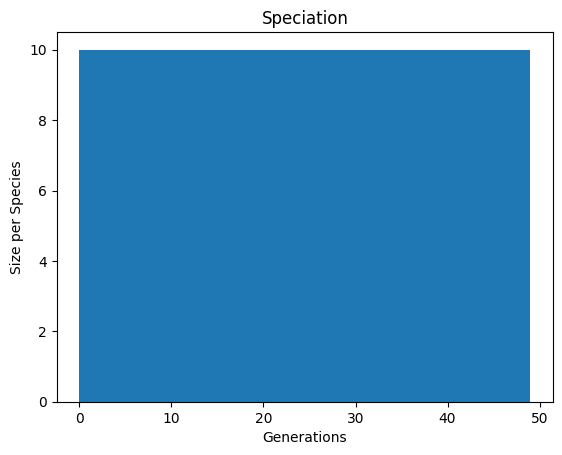

In [9]:
winner = run("laberint.config")

Finalmente evaluamos el mejor cromosoma y lo establecemos

In [10]:
robot['ground-camera'].watch()
world.watch()

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [12]:
# Evaluamos al ganador
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "laberint.config")

winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
fitness(winner_net, 100, real_time=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 0.93 x real time


0

In [ ]:
display("avg_fitness.svg")
winner_net

## Añade al documento pdf que has de enviar al profesor tu reflexión sobre la forma en la que el robot "ha aprendido" a conducir.

Guardaremos el mejor cromosoma para poder usarlo en el futuro.

In [ ]:
with open("winner.pkl", "wb") as f:
    import pickle

    pickle.dump(winner, f)
    f.close()

Cargamos el modelo para verificar que funcione correctamente

In [ ]:
# Cargamos el cromosoma ganador

with open("winner.pkl", "rb") as f:
    import pickle
    winner = pickle.load(f)
    f.close()

# Evaluamos al ganador
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "laberint.config")
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
fitness(winner_net, 30, real_time=True)

  0%|          | 0/300 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 0.94 x real time


0.1945